In [1]:
import numpy as np
import matplotlib.pylab as plt
import random
from scipy.special import comb

import os
import sys
sys.path.append('../src/')
sys.path.append('../scripts/')

import numpy as np  
import networkx as nx
import random
from itertools import combinations

from generators_sc_test import generate_sf_sc_components
from generators_sc_test import check_full_triangle_property

from higher_order_structures import HigherOrderStructure

import importlib
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import sys
import utils
# importlib.reload(utils)

# Scale Free SC - Version with full triangles

In [2]:
# seems to produce reasonable scale-free simplicial complex
# TODO: tune `m_sc`, `gamma_sc`, and perhaps `max_retries_for_stub_set`
# to get distributions that look good and have a sufficient number of simplices

# setup
# m_sc = m_min_kgi: minimum number of target triangles per node 
# gamma_sc = gamma_kgi for HO degrees
N = 1000
m_sc = 2
gamma_sc = 2.5
max_retries_for_stub_set = N // 100

N, sc_edges, sc_triangles, kgi_generated = generate_sf_sc_components(N, m_sc, gamma_sc, max_retries_for_stub_set)

print(f"\nSF-SC with {N} nodes.")
print(f"number of 1-simplices (edges): {len(sc_edges)}")
print(f"number of 2-simplices (triangles): {len(sc_triangles)}")

g_sc = HigherOrderStructure(N)
all_simplices_sc = sc_edges + sc_triangles
g_sc.set_edges(all_simplices_sc)
g_sc.name = f"ScaleFreeSC"
g_sc.print()

pw_degrees_sc = np.zeros(N, dtype=int)
ho_degrees_sc = np.zeros(N, dtype=int)

for i in range(N):
    pw_degrees_sc[i] = len(g_sc.neighbors(i, 1))
    ho_degrees_sc[i] = len(g_sc.neighbors(i, 2))

realized_avg_pw = np.mean(pw_degrees_sc)
realized_max_pw = np.max(pw_degrees_sc)

realized_avg_ho = np.mean(ho_degrees_sc)
realized_max_ho = np.max(ho_degrees_sc)

# 2nd moments (E[X^2] = Var(X) + E[X]^2) around 200?
realized_var_pw = np.var(pw_degrees_sc)
realized_var_ho = np.var(ho_degrees_sc)

realized_2nd_moment_pw = realized_var_pw + np.pow(realized_avg_pw, 2)
realized_2nd_moment_ho = realized_var_ho + np.pow(realized_avg_ho, 2)

print(f"PW:  Avg: {realized_avg_pw:.2f}, Max: {realized_max_pw:.2f}, 2nd moment: {realized_2nd_moment_pw:.2f}")
print(f"HO:  Avg: {realized_avg_ho:.2f}, Max: {realized_max_ho:.2f}, 2nd moment: {realized_2nd_moment_ho:.2f}\n")



SF-SC with 1000 nodes.
number of 1-simplices (edges): 4861
number of 2-simplices (triangles): 1778
	ScaleFreeSC on 1000 nodes with 6639 edges.

PW:  Avg: 9.72, Max: 340.00, 2nd moment: 411.47
HO:  Avg: 5.33, Max: 282.00, 2nd moment: 186.20



	ScaleFreeSC on 1000 nodes with 6639 edges.

Figure saved to: ../figures/higher_order_structures/degree_distributions_scale_free_sc_N1000_m2_gamma2.5.pdf


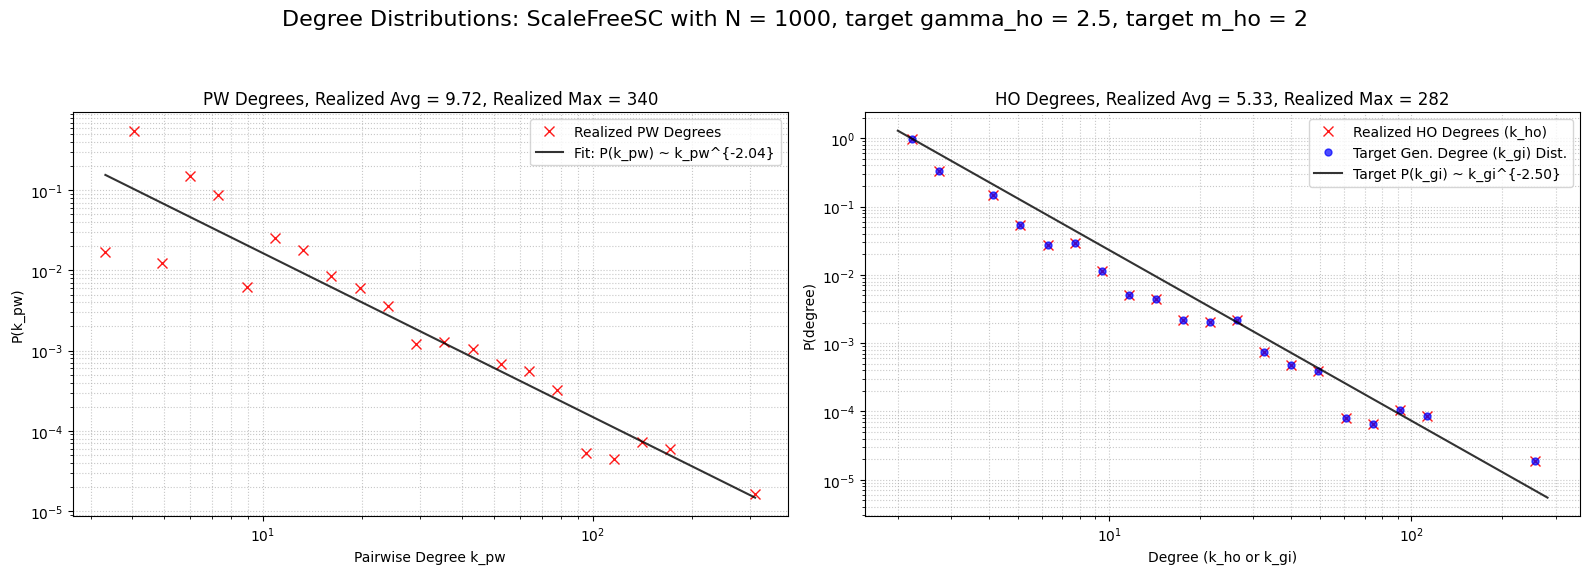

In [3]:
g_sc = HigherOrderStructure(N)
all_simplices_sc = sc_edges + sc_triangles
g_sc.set_edges(all_simplices_sc)
g_sc.name = f"ScaleFreeSC"
g_sc.print()

pw_degrees_sc = np.zeros(N, dtype=int)
ho_degrees_sc = np.zeros(N, dtype=int)

for i in range(N):
    pw_degrees_sc[i] = len(g_sc.neighbors(i, 1))
    ho_degrees_sc[i] = len(g_sc.neighbors(i, 2))
    
figure_fname = f"degree_distributions_scale_free_sc_N{N}_m{m_sc}_gamma{gamma_sc}"
utils.test_generate_sf_sc(pw_degrees_sc, ho_degrees_sc, kgi_generated, N, gamma_sc, m_sc, figure_fname)

In [5]:
check_full_triangle_property(sc_edges, sc_triangles)

Found an empty triangle: (0, 40, 955)


False

In [6]:
N = 1000
m_sc = 2
gamma_sc = 2.5
max_retries_for_stub_set = N // 100

N, sc_edges, sc_triangles, kgi_generated = generate_sf_sc_components(N, m_sc, gamma_sc, max_retries_for_stub_set)

check_full_triangle_property(sc_edges, sc_triangles)

Found an empty triangle: (0, 99, 859)


False

# Compare with `./test/SC_d2_mod.c` version

In [10]:
def load_c_output_edges(filename):
    edges = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                u, v = int(parts[0]), int(parts[1])
                edges.append(tuple(sorted((u, v)))) # Store as sorted tuple
    return list(set(edges)) # Return unique edges

def load_c_output_triangles(filename):
    triangles = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                u, v, w = int(parts[0]), int(parts[1]), int(parts[2])
                triangles.append(tuple(sorted((u, v, w)))) # Store as sorted tuple
    return list(set(triangles)) # Return unique triangles

In [11]:
# used the same values of parameters
# N = 1000
# m_sc = 2
# gamma_sc = 2.5

sc_edges_fname = "../tests/SC_d2_edges.txt"
sc_triangles_fname = "../tests/SC_d2_triangles.txt"

c_sc_edges = load_c_output_edges(sc_edges_fname)
c_sc_triangles = load_c_output_triangles(sc_triangles_fname)

print(f"number of edges {len(c_sc_edges)}")
print(f"number of triangles: {len(c_sc_triangles)}")

g_sc_c = HigherOrderStructure(N)
g_sc_c.set_edges(c_sc_edges + c_sc_triangles)
g_sc_c.name = f"ScaleFreeSC_mod_c"
g_sc_c.print()

number of edges 4658
number of triangles: 1602
	ScaleFreeSC_mod_c on 1000 nodes with 6260 edges.



Figure saved to: ../figures/higher_order_structures/degree_distributions_scale_free_sc_N1000_m2_gamma2.5_mod_c.pdf


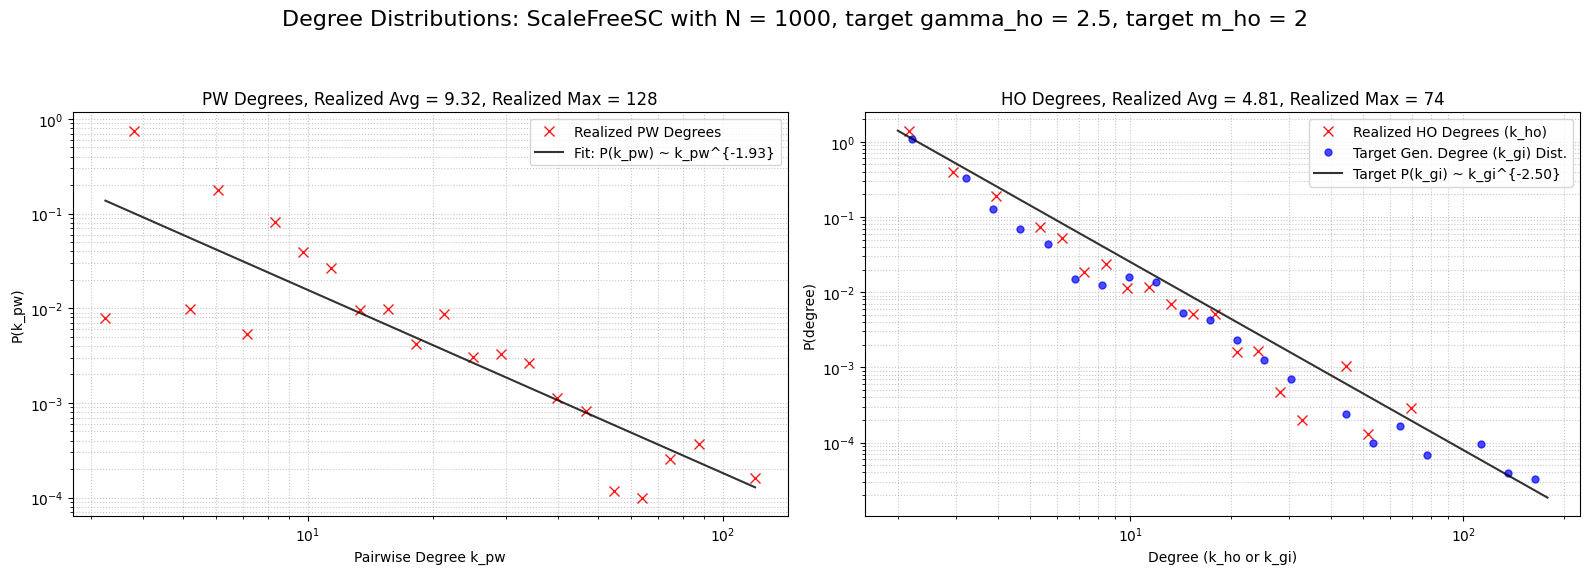

In [13]:
pw_degrees_from_c = np.zeros(N, dtype=int)
ho_degrees_from_c = np.zeros(N, dtype=int)
for i in range(N):
    pw_degrees_from_c[i] = len(g_sc_c.neighbors(i, 1))
    ho_degrees_from_c[i] = len(g_sc_c.neighbors(i, 2))

kgi_target_for_plot = np.zeros(N, dtype=int)
for i in range(N):
    u = random.random()
    while u == 0.0: 
        u = random.random()
    
    drawn_kgi = int(m_sc * (u**(-1.0 / (gamma_sc - 1.0))))
    kgi_target_for_plot[i] = max(m_sc, drawn_kgi)
    
    max_poss_tri_node = (N - 1) * (N - 2) / 2.0
    kgi_target_for_plot[i] = min(kgi_target_for_plot[i], int(max_poss_tri_node))

    if kgi_target_for_plot[i] < 0: 
        kgi_target_for_plot[i] = 0

figure_fname = f"degree_distributions_scale_free_sc_N{N}_m{m_sc}_gamma{gamma_sc}_mod_c"
utils.test_generate_sf_sc(pw_degrees_from_c, ho_degrees_from_c, kgi_target_for_plot, N, gamma_sc, m_sc, figure_fname)        

In [15]:
check_full_triangle_property(c_sc_edges, c_sc_triangles)

Found an empty triangle: (0, 118, 227)


False